In [49]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
####################################################################################
#    Aggregates SNR (.dat), latency (.dat), and ROI photos (png)
#            scraped from PhotoZ
#    Given ROI files in format slice#_rois.dat 
# 8/23/23 We want to add:
#     Take into account the RELATIVE STIM LOCATION within every barrel. Does velocity depend on distance from stimulating location?
#            New column: distance (um) from stim loc to relevant barrel pair boundary (1:2)
#            New column: distance (um) from stim loc to relevant barrel pair boundary (2:3)
#
#     METHOD
#         To calculate stim location to boundary, take these files produced by MovieMaker2.ipynb:
#             electrode.dat
#             corners_layer.dat
#             corners_barrel.dat
#         Calculate: Distance to lower barrel, distance to higher barrel,
#                    Distance to lower layer, distance to higher layer
#                       (if applicable for each)
####################################################################################

In [14]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
data_dir = 'C:/Users/jjudg/Downloads/'
cell_type_prefix = 'scnn1a'
csv_prefix = cell_type_prefix + '_all_slices-final.csv'

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df

,Date,Slice/Loc/Rec,Slice Edge,Medial Dir,Slice Location,Stim Location,L4 barrel 1 Latency,L4 barrel 2 Latency,L4 barrel 3 Latency,L4 barrel 1 SNR,...,abs(delta 1),abs(delta 2),Distance to Barrel 1,Distance to Barrel 2,Distance to Layer n1,Distance to Layer n2,Distance to Barrel A,Distance to Barrel B,Distance to Layer nA,Distance to Layer nB
0,2/8/2023,02_01_02,NaN,NaN,NaN,L4,47.7369,49.4509,49.8291,1.55191,...,NaN,NaN,NaN,NaN,NaN,NaN,215.228351,174.000000,180.093736,191.535134
1,2/10/2023,04_01_07,NaN,NaN,NaN,L4,52.7236,49.9505,51.1170,6.20749,...,2.7731,NaN,NaN,NaN,NaN,NaN,151.086327,213.337695,149.891961,202.354632
2,2/14/2023,02_01_01,NaN,NaN,NaN,L4,47.5447,49.7343,49.9818,2.20928,...,NaN,NaN,NaN,NaN,NaN,NaN,198.974687,232.730513,132.022414,229.523778
3,2/14/2023,03_01_03,NaN,NaN,NaN,L4,51.1559,50.3250,51.2512,4.77084,...,NaN,0.9262,NaN,NaN,NaN,NaN,228.000000,162.000000,159.011987,199.155462
4,2/28/2023,02_01_01,NaN,NaN,NaN,L5,50.3009,50.8406,49.3457,2.94039,...,NaN,1.4949,NaN,NaN,NaN,NaN,44.346286,328.107622,171.794234,154.795349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,10/19/2023,05_06_02,down/right,down/left,Anterior,L2/3,52.5402,51.2761,54.6519,5.21410,...,1.2641,NaN,NaN,NaN,NaN,NaN,24.997803,181.431965,314.744870,103.797327
170,10/19/2023,06_01_01,down,right,Posterior,L4,50.6833,50.3330,49.7638,10.10250,...,0.3503,NaN,NaN,NaN,NaN,NaN,118.898651,202.376373,288.667605,69.296479
171,10/19/2023,06_02_02,down,right,Posterior,L4,50.3022,51.0678,52.1046,27.20220,...,0.7656,1.0368,NaN,NaN,NaN,NaN,151.005549,215.305522,75.027164,306.897033
172,10/19/2023,06_03_01,down,right,Posterior,L2/3,52.3050,51.7377,50.8937,8.65164,...,0.5673,NaN,NaN,NaN,NaN,NaN,322.923386,22.555042,70.935246,350.093066


In [27]:
# filter out rows marked in column Exclude 
df2 = df[df["Exclude Reason"].isnull()]
data = {}

for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    print("Barrel pairs in", stim_loc)
    # count number of barrel pairs with no signal crossing
    n_barrel_no_cross = len(df2[df2['# no crossings 2/3'] > 0])
    n_barrel_no_cross += len(df2[df2['# no crossings 1/2'] > 0])
    print("\t", n_barrel_no_cross, "no crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with signal crossing
    n_barrel_cross = len(df2[df2['# crossings 2/3'] > 0])
    n_barrel_cross += len(df2[df2['# crossings 1/2'] > 0])
    print("\t", n_barrel_cross, "crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with no signal
    n_barrel_none = len(df2) * 2 - n_barrel_cross - n_barrel_no_cross
    print("\t", n_barrel_none, "no signal out of", len(df2) * 2, "in layer", stim_loc)
    
    data[stim_loc] = {}
    data[stim_loc]['n_barrel_no_cross'] = n_barrel_no_cross
    data[stim_loc]['n_barrel_cross'] = n_barrel_cross
    data[stim_loc]['n_barrel_none'] = n_barrel_none
    data[stim_loc]['total'] = len(df2) * 2 - n_barrel_none

Barrel pairs in L2/3
	 19 no crossing out of 122 in layer L2/3
	 46 crossing out of 122 in layer L2/3
	 57 no signal out of 122 in layer L2/3
Barrel pairs in L4
	 68 no crossing out of 194 in layer L4
	 35 crossing out of 194 in layer L4
	 91 no signal out of 194 in layer L4
Barrel pairs in L5
	 10 no crossing out of 28 in layer L5
	 7 crossing out of 28 in layer L5
	 11 no signal out of 28 in layer L5


In [50]:
# This is a binomial experiment of n independent trials.
# We use the Binomial case of goodness of fit test to a 
# chi-squared distribution
Zs = []
for i in range(3):
    layer = ['L2/3', 'L4', 'L5'][i]
    n = [n_L23, n_L4, n_L5][i]
    no_cr = crossing_data['# no crossing'][i]
    cr = crossing_data['# crossing'][i]
    k = n * cr / 100 # number of crosses
    
    null_hyp_p = 0.5
    
    Z = binom_test(k, n, null_hyp_p, alternative='greater')
    if Z > 0.5:
        Z = 1 - Z
    print("Binomial test for layer", layer, ":", Z)
    Zs.append(Z)

Binomial test for layer L2/3 : 0.0005450419022237896
Binomial test for layer L4 : 0.0003637852893366711
Binomial test for layer L5 : 0.0717315673828125


{'# no crossing': [6.70599837467796, 8.006030341005166, 18.601633295108112], '# crossing': [10.43435382019272, 5.743766779708365, 15.563243006262297]}
{'# no crossing': [29.23076923076923, 66.01941747572815, 58.8235294117647], '# crossing': [70.76923076923077, 33.980582524271846, 41.17647058823529]}


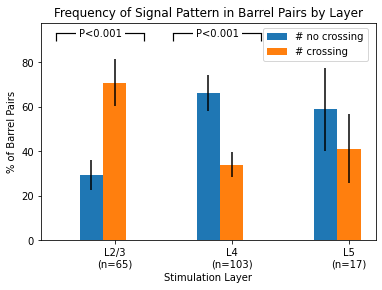

In [66]:
def significance_bar(start,end,height,displaystring,linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height,displaystring,ha = 'center',va='center',bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)


plt.clf()
i = 0
tick_labels = []
colors = {"# no crossing": 'tab:blue', "# crossing": 'tab:orange'}
# in format # no crossing, # crossing, # no signal; l2/3, L4, L5

length_of_previous_sl = i

n_L23 = data['L2/3']['total']
n_L4 = data['L4']['total']
n_L5 = data['L5']['total']

all_layers = []
totals = []
if n_L23 > 0:
    all_layers.append('L2/3')
    totals.append(n_L23)
if n_L4 > 0:
    all_layers.append('L4')
    totals.append(n_L4)
if n_L5 > 0:
    all_layers.append('L5')
    totals.append(n_L5)


# in columns L23, L4, L5
crossing_data = {
    "# no crossing": [data[x]['n_barrel_no_cross'] for x in all_layers],
    '# crossing': [data[x]['n_barrel_cross'] for x in all_layers],
    #'# no signal': [data[x]['n_barrel_none'] for x in ['L2/3', 'L4', 'L5']],
    #"L2/3": [3, 17, 30],
    #"L4": [38, 20, 30],
    #"L5": [8, 13, 1]
}
errbars = {}
for k in crossing_data:
    errbars[k] = [np.sqrt(x) for x in crossing_data[k]]
    for j in range(len(totals)):
        crossing_data[k][j] /= totals[j] / 100
        errbars[k][j] /= totals[j] / 100

labels = [x for x in crossing_data.keys()]
tick_labels += [all_layers[j] + "\n(n="+str(totals[j]) + ")"
                            for j in range(len(all_layers))]

print(errbars)
print(crossing_data)
    
##########################
for nm in crossing_data:
    x = np.arange(len(all_layers))
    # else:
    plt.bar(x + (i-1) * 0.2, 
        crossing_data[nm],
        0.2,
        label=(nm if length_of_previous_sl == 0 else None),
        color=colors[nm])
    plt.errorbar(x + (i-1) * 0.2, 
                crossing_data[nm],
                yerr=errbars[nm],
                fmt='none',
                color='black')
    i += 1

for i in range(3):
    if Zs[i] < 0.001:
        significance_bar(i-.5, i+0.25, 93, "P<0.001", fontsize=10)
    
plt.title("Frequency of Signal Pattern in Barrel Pairs by Layer")
plt.xlabel("Stimulation Layer")
plt.ylabel("% of Barrel Pairs")
#plt.xticks(rotation='vertical')
plt.xticks(np.arange(len(tick_labels)), tick_labels)
plt.legend(bbox_to_anchor=(0.82, 1.0), loc='upper center')
plt.savefig(data_dir + "results_count_sept2023.png")
plt.show()

In [8]:
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    dfd1 = df2['abs(delta 1)'].dropna()
    dfd2 = df2['abs(delta 2)'].dropna()

    print("Latency between barrel pairs in", stim_loc)
    dfds = np.concatenate([dfd1, dfd2])
    print("\t", 
          str(np.mean(dfds))[:5], 
          "+/-", 
          str(np.std(dfds))[:5], 
          "(n =", 
          str(len(dfds)) + ")")
    print("\t", dfds)

Latency between barrel pairs in L2/3
	 0.545 +/- 0.417 (n = 5)
	 [0.2138 0.2299 0.7214 0.2692 1.2911]
Latency between barrel pairs in L4
	 1.188 +/- 0.874 (n = 8)
	 [2.7731 0.0717 1.222  0.9262 0.957  1.3192 0.0676 2.1705]
Latency between barrel pairs in L5
	 1.043 +/- 0.473 (n = 2)
	 [0.5704 1.5165]
